Nicolás Almaraz - UTN FRBA

<H1><center>Tarea Semanal 8: Filtros Digitales</center></H1>

<center><H2>Preparo Workspace</H2></center>

In [1]:
# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

import scipy.signal as sig
import scipy.io as sio

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
from pytc2.sistemas_lineales import plot_plantilla

<center><H2>Plantilla objetivo</H2></center>

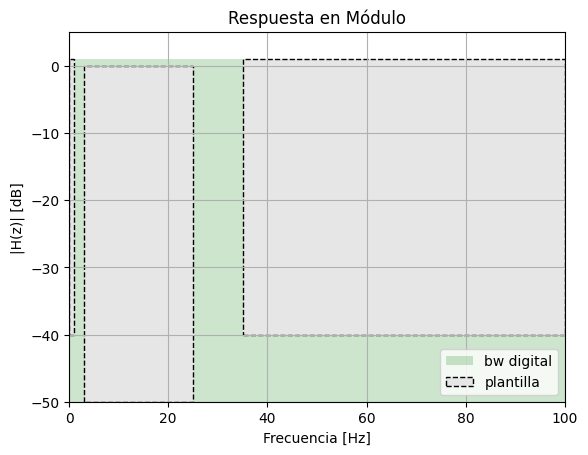

In [2]:
# Muestreo
fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla
ripple = 0 # dB
atenuacion = 40 # dB
ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

plt.title('Respuesta en Módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(z)| [dB]')
plt.xlim(0, 100)
plt.ylim(-50, 1)
plt.grid()
plot_plantilla(filter_type = 'bandpass', fpass = (wp1,wp2), ripple = ripple , fstop = (ws1,ws2), attenuation = atenuacion, fs = fs)
plt.show()

<H2><center>Parte 1: Diseño de Filtros</center></H2>

<H3><center>Diseño IIR</center></H3>
Para diseñar el filtro IIR uso la funcion IIR design a la cual hay que pasarle los datos de la plantilla y la frecuencia de muestreo del sistema

In [3]:
fs = 1000 # Hz
nyq_frec = fs / 2

# Especifica las frecuencias de corte y las atenuaciones
ripple = 0.00000000001  # dB
atenuacion = 40  # dB
ws1 = 1.0  # Hz
wp1 = 3.0  # Hz
wp2 = 25.0  # Hz
ws2 = 35.0  # Hz

# Diseña el filtro Butterworth
sosIIR = sig.iirdesign( wp=[wp1, wp2], ws=[ws1, ws2], gpass=ripple, gstop=atenuacion, analog=False,
ftype='butter', output='sos', fs=1000)

# Calcula la respuesta en frecuencia del filtro
w, h = sig.sosfreqz(sosIIR)
wIIR = w / np.pi * nyq_frec

moduloIIR = 20*np.log10(abs(h))
faseIIR = np.angle(h)*180/np.pi

ejeMuestrasIIR = w*(2*np.pi/fs)
retardoGrupoIIR = -np.diff(faseIIR) / np.diff(ejeMuestrasIIR)


#### Respuesta en Módulo

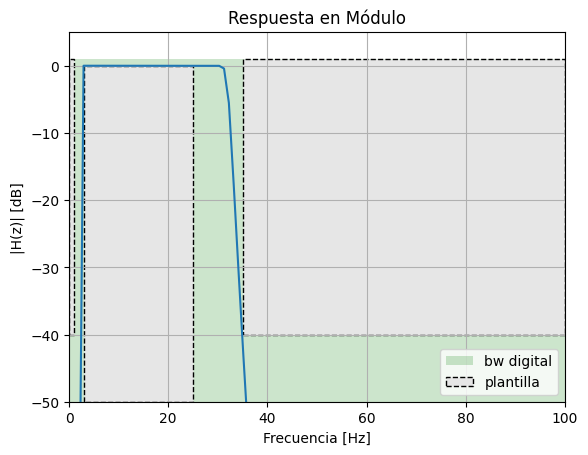

In [4]:
plt.plot(wIIR, moduloIIR)
plt.title('Respuesta en Módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(z)| [dB]')
plt.xlim(0, 100)
plt.ylim(-50, 1)
plt.grid()
plot_plantilla(filter_type = 'bandpass', fpass = (wp1,wp2), ripple = ripple , fstop = (ws1,ws2), attenuation = atenuacion, fs = fs)
plt.show()

#### Respuesta en Fase

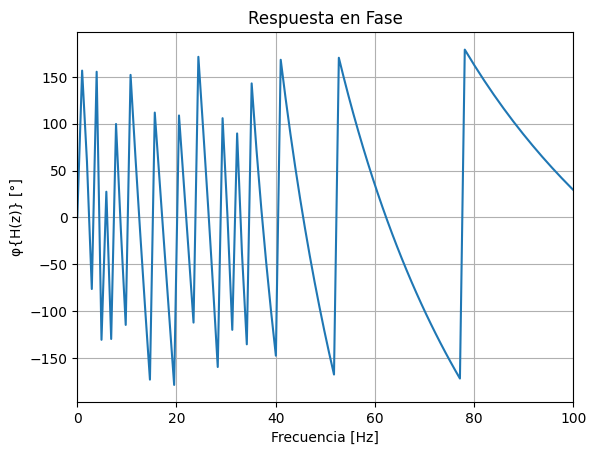

In [5]:
plt.plot(wIIR, faseIIR)
plt.title('Respuesta en Fase')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('φ{H(z)} [°]')
plt.xlim(0, 100)
plt.grid()
plt.show()

#### Retardo de Grupo

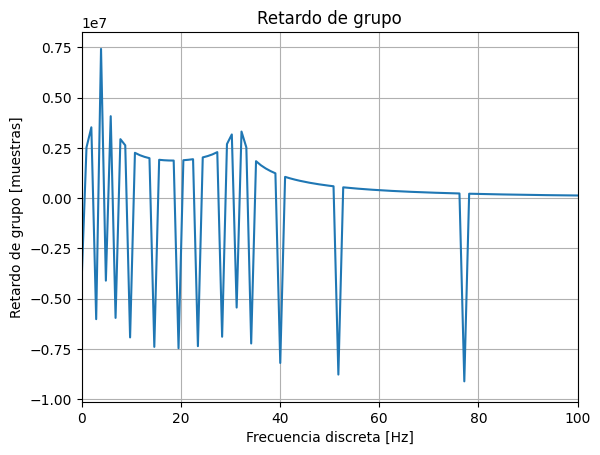

In [6]:
plt.plot(wIIR[:-1], retardoGrupoIIR)
plt.title('Retardo de grupo')
plt.xlabel('Frecuencia discreta [Hz]')
plt.ylabel('Retardo de grupo [muestras]')
plt.xlim(0, 100)
plt.grid()
plt.show()

#### Respuesta al Impulso

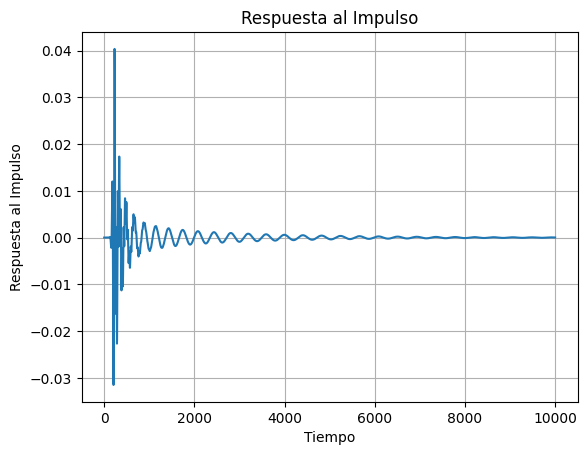

In [7]:
# Generar la respuesta al impulso del filtro IIR
N=10000
impulse = np.zeros(N)
impulse[0] = 1.0
impulse_response = sig.sosfilt(sosIIR,impulse)
N = len(impulse_response)
times = np.arange(N)
plt.plot(times, impulse_response)
plt.xlabel('Tiempo')
plt.ylabel('Respuesta al Impulso')
plt.title('Respuesta al Impulso')
plt.grid()
plt.show()

<H3><center>Diseño FIR</center></H3>
Para diseñar el filtro FIR podría utilizar la funcion firwin2 en modo pasabandas.
Sin embargo, utilizaré dicha función primero como un pasaaltos y luego como un pasabajos para luego combinar ambas transferencias resultando en una pasabandas.

In [8]:
fs = 1000 # Hz
nyq_frec = fs / 2

# Plantilla

# filter design
ripple = 0 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz

#####################
#Plantilla Pasa altos
#####################
cant_coeficientes = 3001
frecs = np.array([0.0,         ws1,         wp1, nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple])
gains = 10**(gains/20)
num_pa = sig.firwin2(cant_coeficientes, frecs, gains , window='lanczos' )
den_pa = 1.0


#####################
#Plantilla Pasa bajos
#####################
cant_coeficientes = 2001
frecs = np.array([0, wp2, ws2, nyq_frec]) / nyq_frec
gains = np.array([-ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)
num_pb = sig.firwin2(cant_coeficientes, frecs, gains , window='hamming' )
den_pb = 1.0


#####################
#Formo Transferencia final
#####################
numFIR = np.polymul(num_pb,num_pa)
denFIR = np.polymul(den_pb,den_pa)


#####################
#Calculo respuesta en modulo fase y retardo grupo
#####################

w  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, h = sig.freqz(numFIR, denFIR, w)
wFIR = w / np.pi * nyq_frec

moduloFIR = 20*np.log10(abs(h))

faseFIR = np.angle(h)*180/np.pi

ejeMuestrasFIR = w*(2*np.pi/fs)
retardoGrupoFIR = -np.diff(faseFIR) / np.diff(ejeMuestrasFIR)

#### Respuesta en Módulo

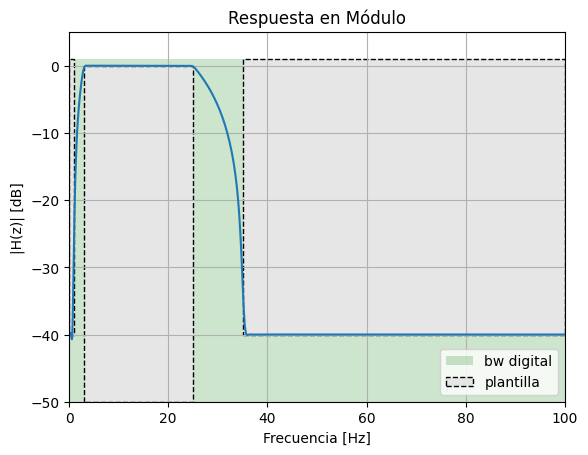

In [9]:
plt.plot(wFIR, moduloFIR)
plt.title('Respuesta en Módulo')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('|H(z)| [dB]')
plt.xlim(0, 100)
plt.ylim(-50, 1)
plt.grid()
plot_plantilla(filter_type = 'bandpass', fpass = (wp1,wp2), ripple = ripple , fstop = (ws1,ws2), attenuation = atenuacion, fs = fs)
plt.show()

#### Respuesta en Fase

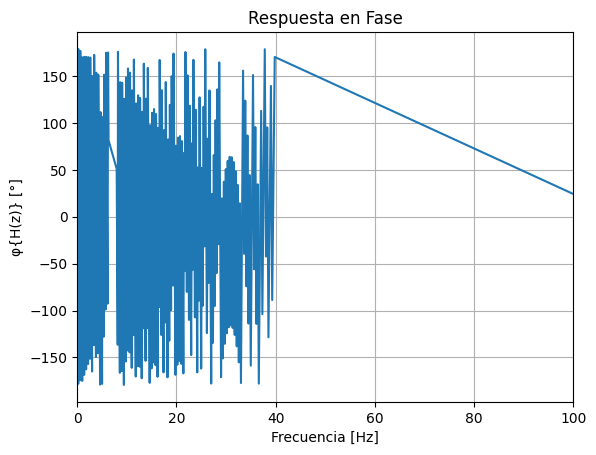

In [10]:
plt.plot(wFIR, faseFIR)
plt.title('Respuesta en Fase')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('φ{H(z)} [°]')
plt.xlim(0, 100)
plt.grid()
plt.show()

#### Retardo de Grupo

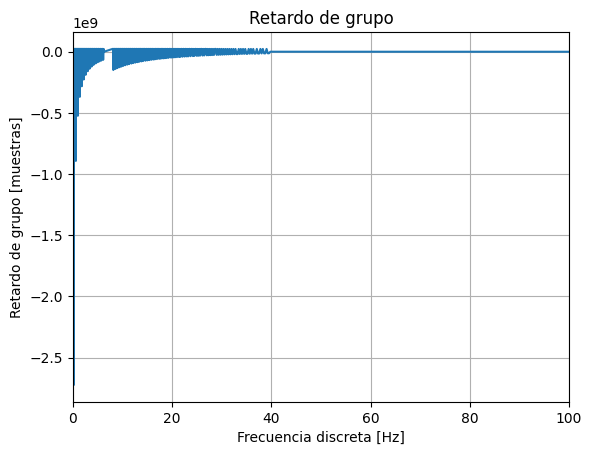

In [11]:
plt.plot(wFIR[:-1], retardoGrupoFIR)
plt.title('Retardo de grupo')
plt.xlabel('Frecuencia discreta [Hz]')
plt.ylabel('Retardo de grupo [muestras]')
plt.xlim(0, 100)
plt.grid()
plt.show()

#### Respuesta al Impulso

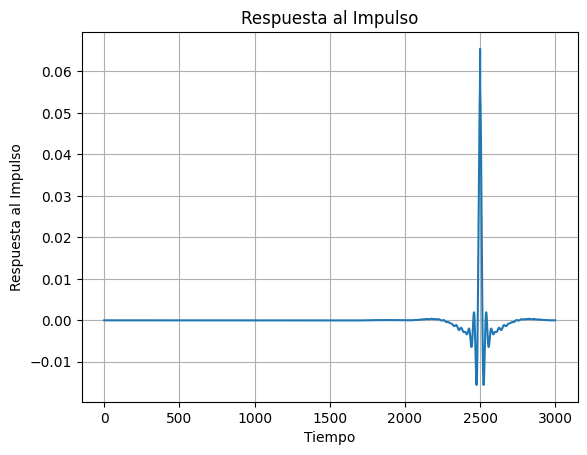

In [12]:
N=3000
impulse = np.zeros(N)
impulse[0] = 1.0
respuesta_impulso = sig.lfilter(numFIR, denFIR, impulse)
N = len(respuesta_impulso)
times = np.arange(N)
plt.plot(times, respuesta_impulso)
plt.xlabel('Tiempo')
plt.ylabel('Respuesta al Impulso')
plt.title('Respuesta al Impulso')
plt.grid()
plt.show()

<H2><center>Parte 2: Implementación y Uso</center></H2>
Utilizo filtros para la señal contenida en el archivo ECG.mat

Tanto en el FIR como en el IIR voy a graficar primero aplicando el filtro normalmente, es decir, simulando un caso de tiempo real.

Luego, voy a aplicar el filtro usando un algoritmo bidireccional de tal manera que coincida la señal real con la filtrada

<H3><center>Levanto archivo</center></H3> 

In [13]:
fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

<H3><center>Filtrado con IIR</center></H3>


#### Aplico filtro en zonas de alta contaminación

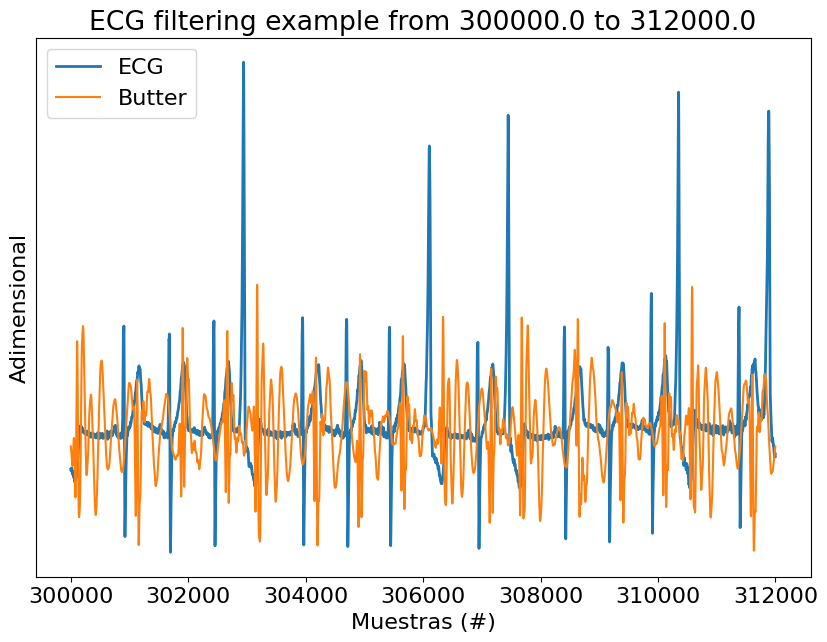

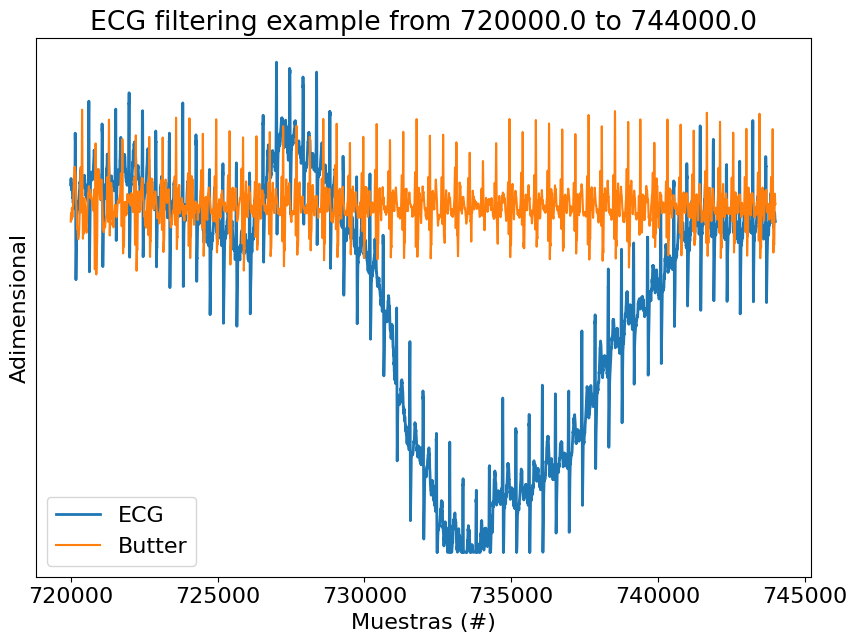

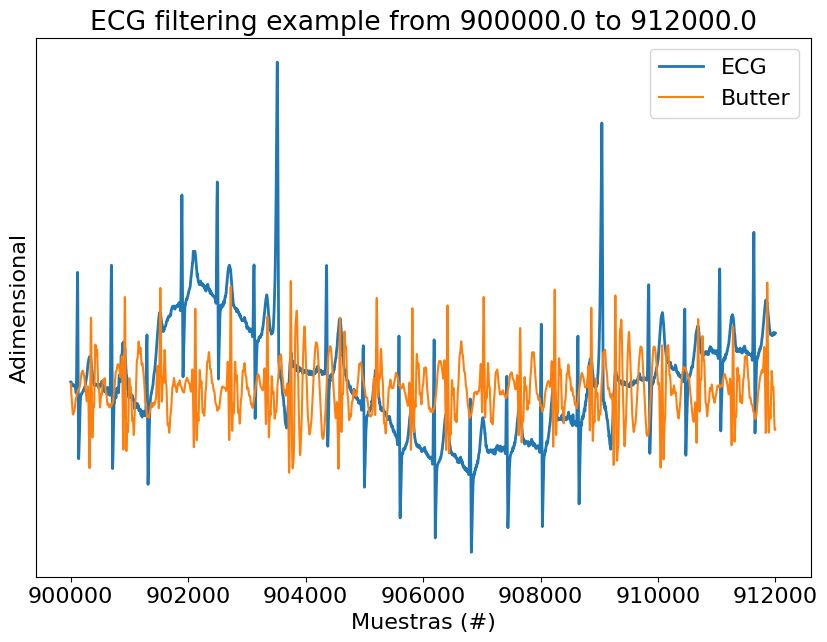

In [14]:
# IIR
ECG_f_butt = sig.sosfilt(sosIIR, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.

demora = 0 #No encuentro la demora correspondiente para este filtro

# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region+demora], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Aplico filtro en zonas de baja contaminación

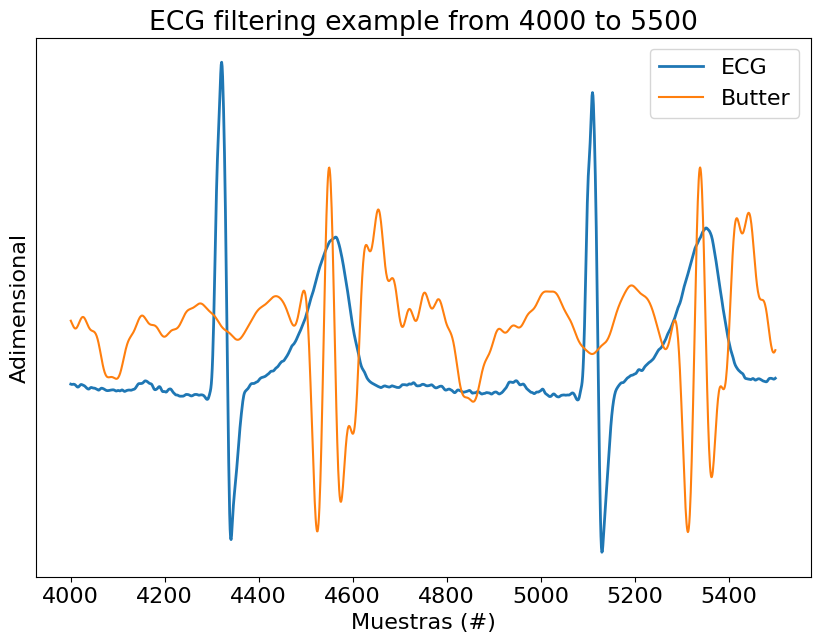

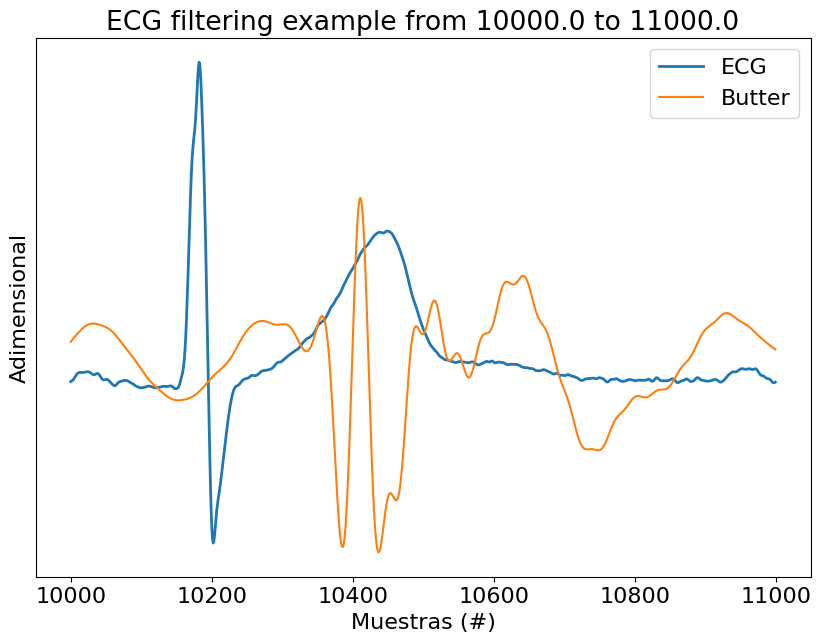

In [15]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region+demora], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()


#### Aplico filtro bidireccional en zonas de alta contaminación

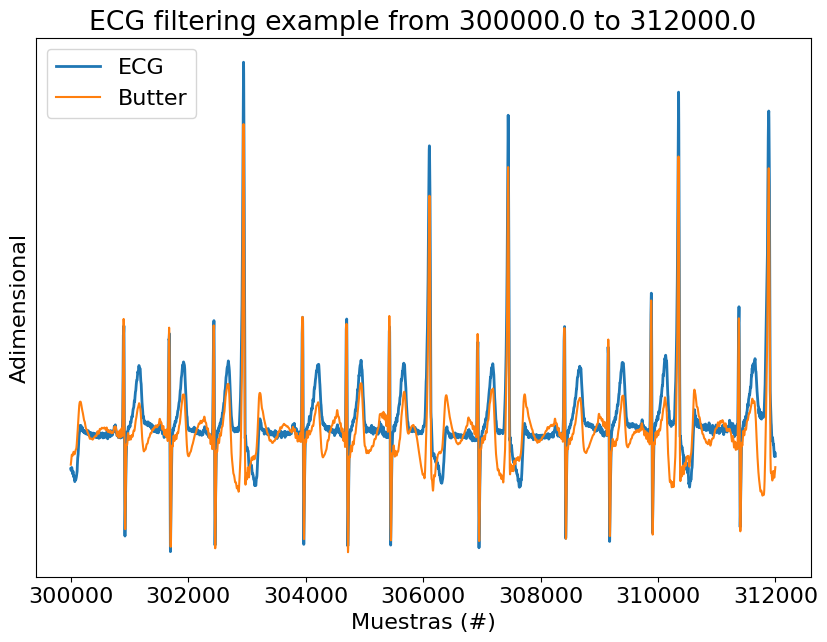

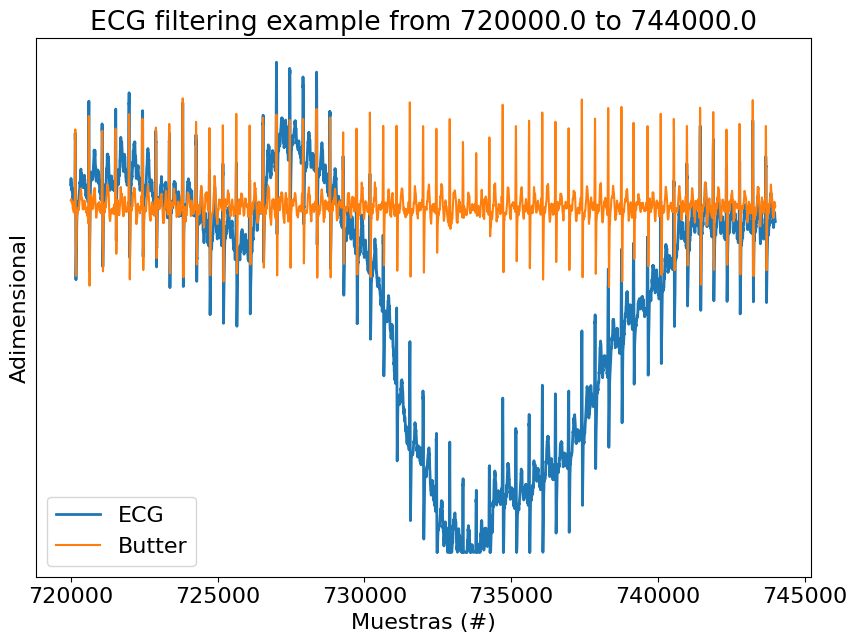

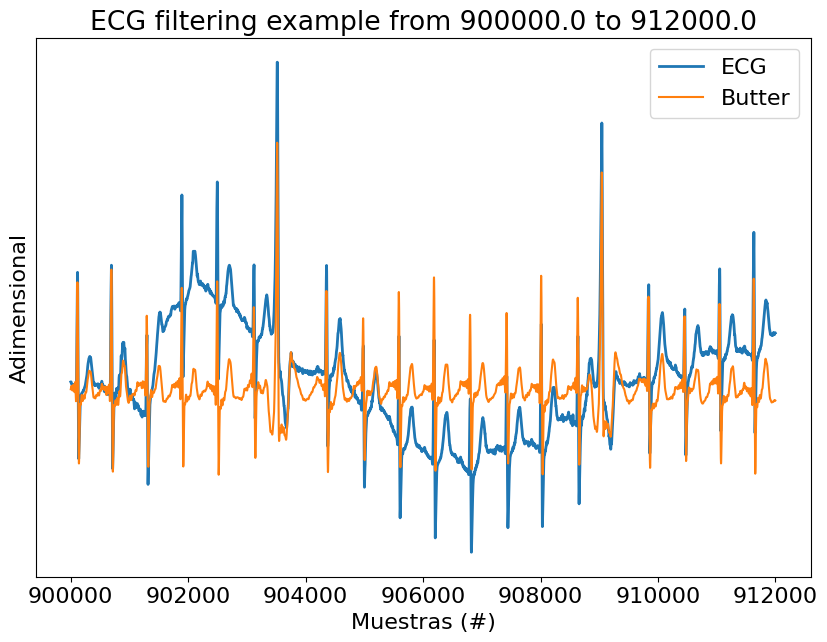

In [16]:
# Procedemos al filtrado
ECG_f_butt = sig.sosfiltfilt(sosIIR, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Aplico filtro bidireccional en zonas de baja contaminación

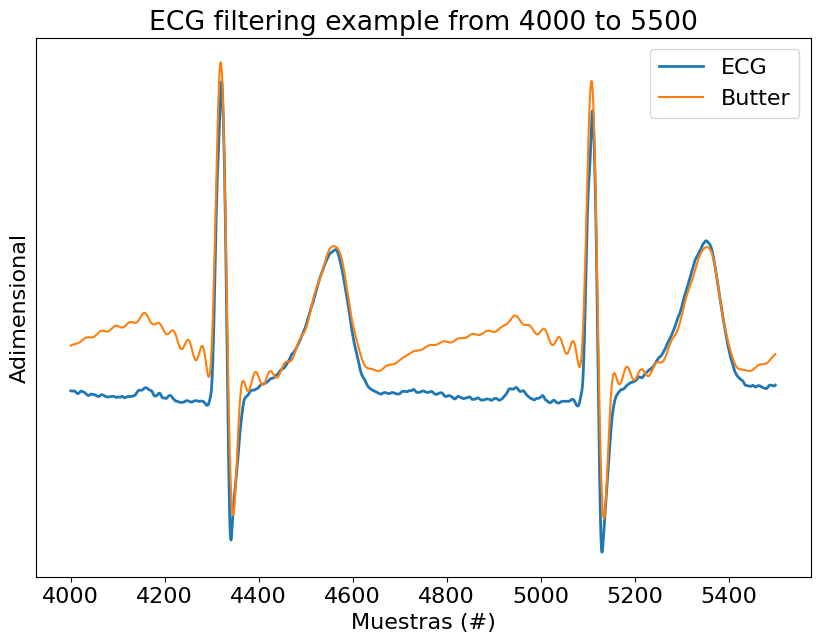

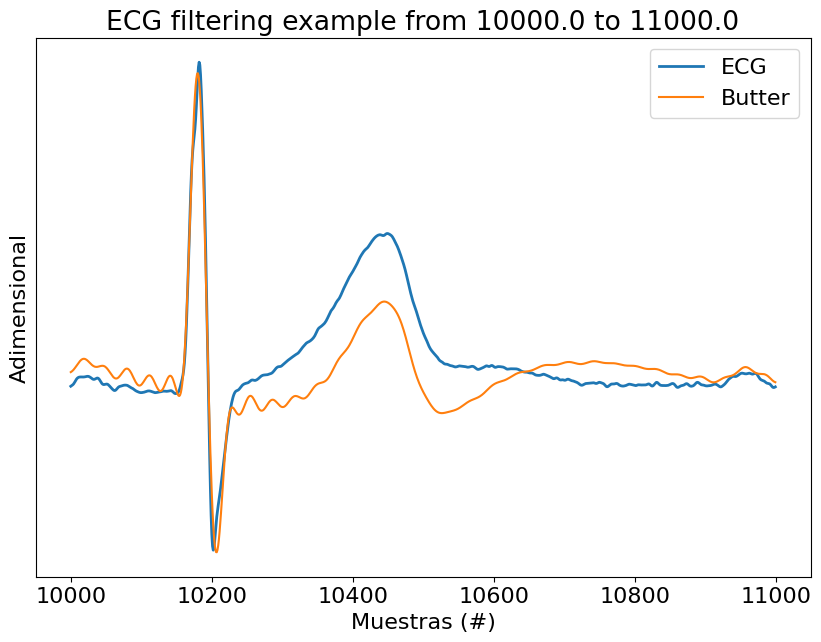

In [17]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_butt[zoom_region+demora], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

<H3><center>Filtrado con FIR</center></H3>

#### Aplico filtro en zonas de alta contaminación

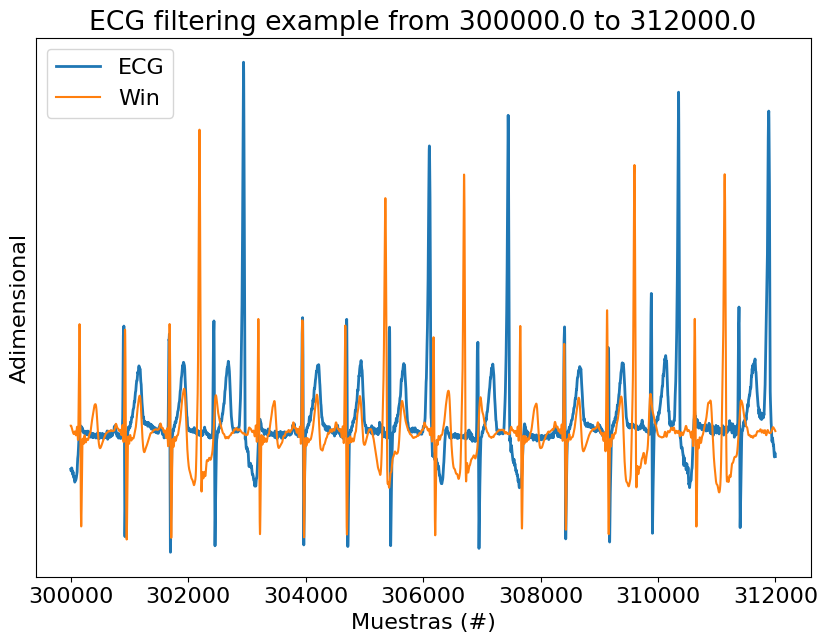

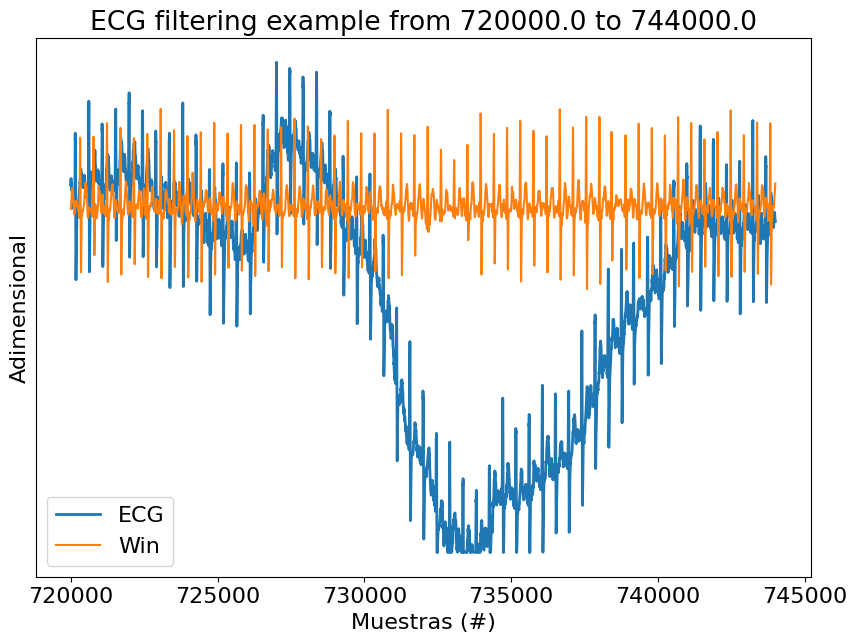

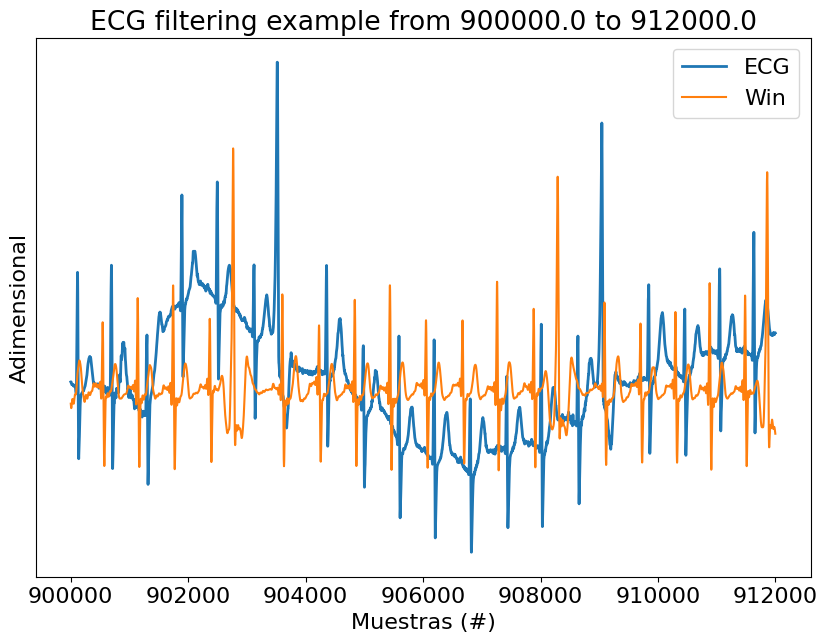

In [18]:
# FIR
ECG_f_win = sig.filtfilt(numFIR, denFIR, ecg_one_lead)

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Aplico filtro en zonas de baja contaminación

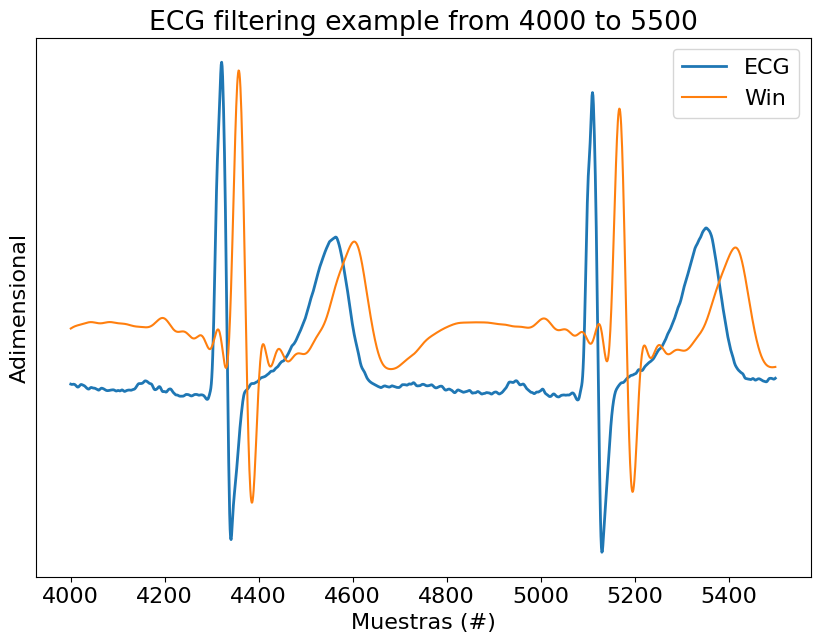

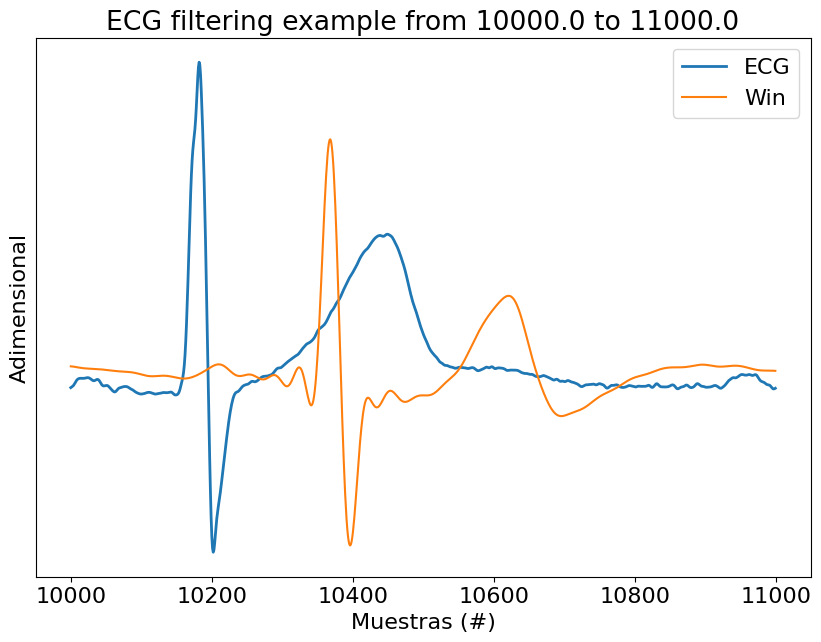

In [19]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Aplico filtro bidireccional en zonas de alta contaminación

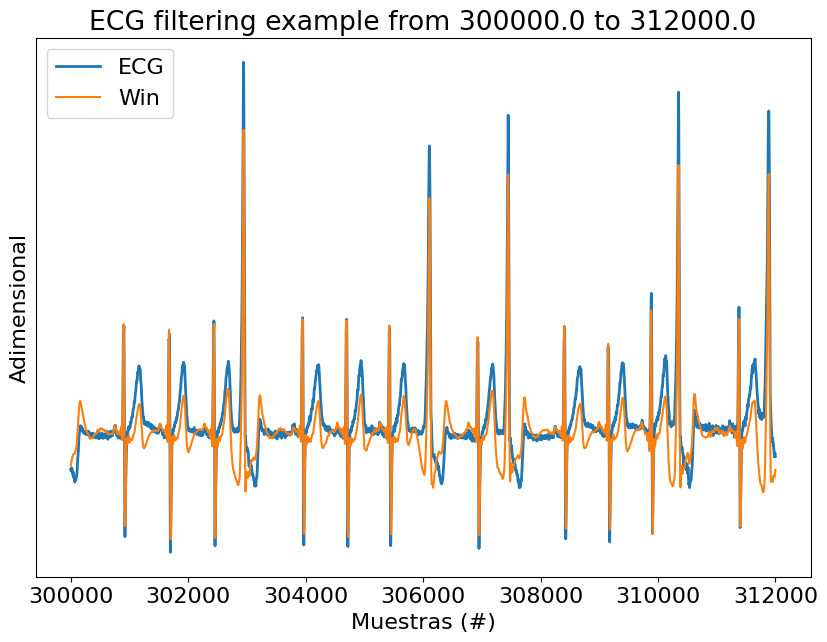

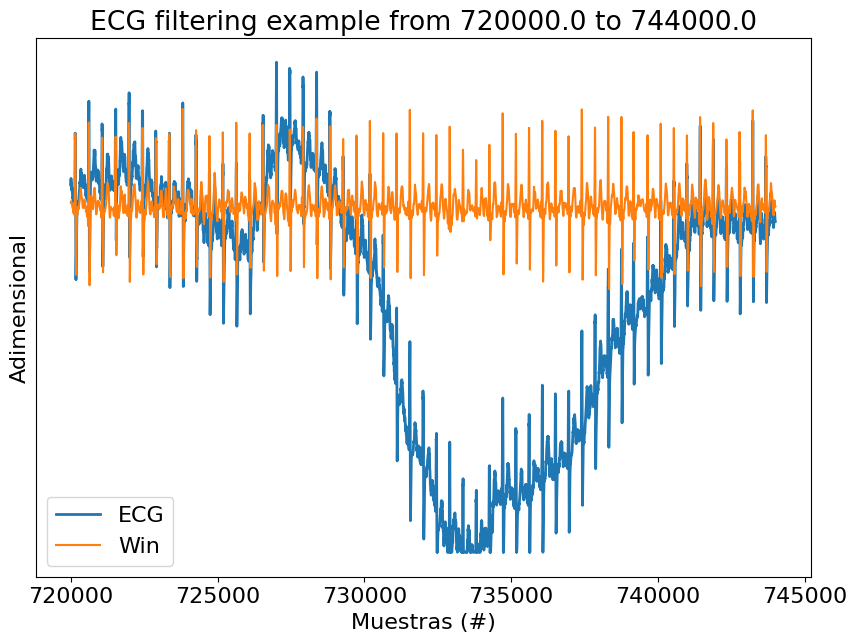

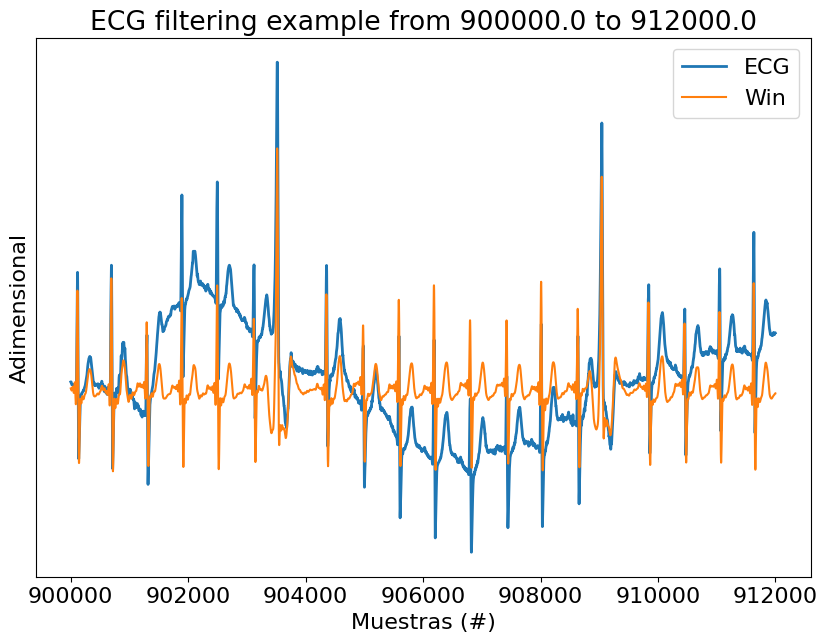

In [20]:
# Procedemos al filtrado
ECG_f_win = sig.filtfilt(numFIR, denFIR, ecg_one_lead)

# Segmentos de interés
regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

#### Aplico filtro bidireccional en zonas de baja contaminación

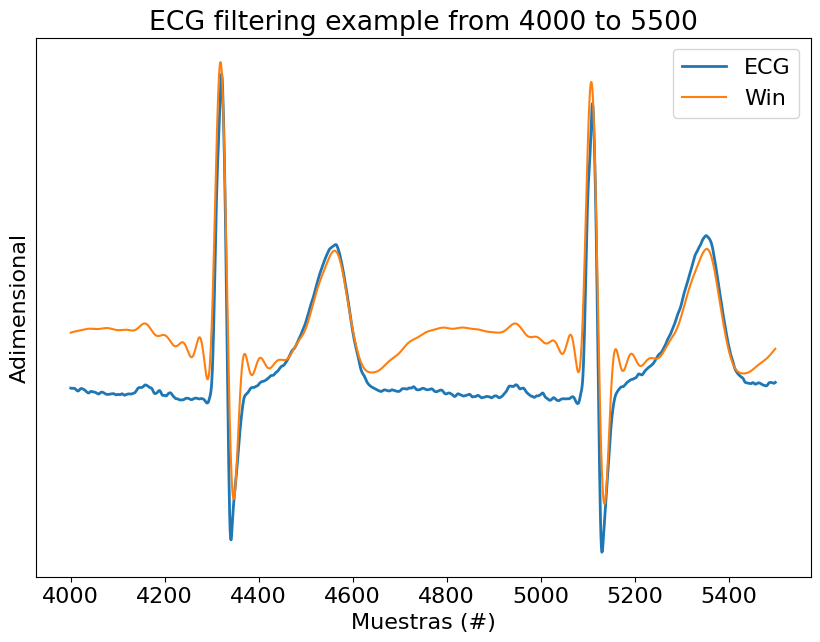

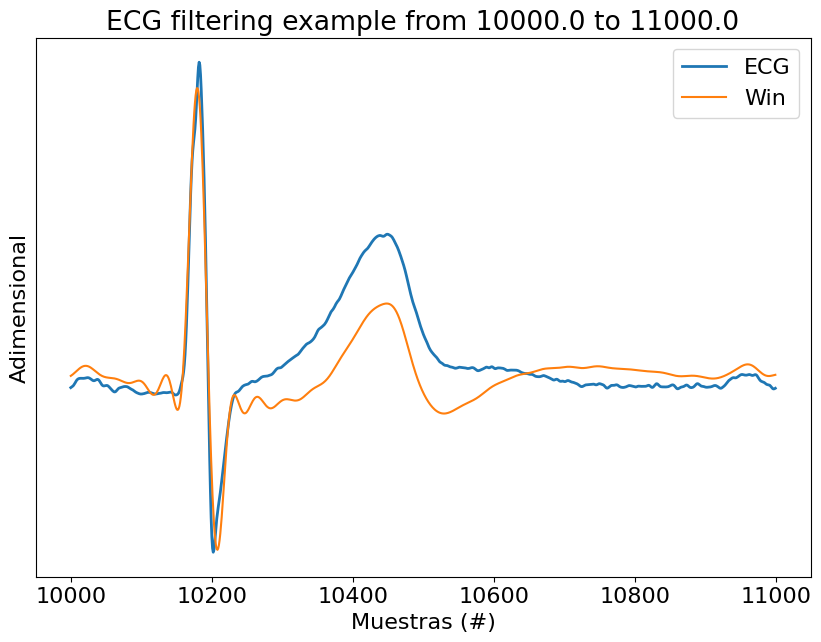

In [21]:
regs_interes = ( 
        [4000, 5500], # muestras
        [10e3, 11e3], # muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', lw=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region], label='Win')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

<H2><center>Conclusiones</center></H2>

En los gráficos anteriores se utiliza el filtrado bidireccional para poder comparar más cómodamente las respuestas de los filtros (naranja) frente a la señal original (azul).

Puedo decir que ambos filtros eliminan bien las bajas frecuencias de las zonas muy contaminadas.
Sin embargo, en las zonas donde debería dejar pasar la señal, esta termina deformandose principalmente en las bajas frecuencias. Estas observaciones aplican para los dos filtros.

Curiosamente la señal se desforma principalemente en las bajas frecuencias luego de que venga un pico.

Dado que la forma que tiene la señal es del tipo
"Pico HF", "Plano LF", "Pico HF", "Plano LF", "Pico HF", "Plano LF", etc.

Creo que sería inteligente usar un filtro apra analizar los picos y otro filtro disitnto para analizar las llanuras.

Digo esto porque pienso que debido a los retardos de grupo, el pico de alta frecuencia está "tapando" el correcto análisis de las llanuras de la señal. En consecuencia, habría que conseguir o bien un filtro muy rápido, o bien analizar ambas partes de la señal por separado.